# PupilAnalysisPy - Tratamento do Sinal Pupilar

#### Este algoritmo serve para:
- Fazer o tratamento e preprocessamento do sinal
    - Remover células vazias (outliers)
    - Calcular perda de sinal
    - Reconstruir intervalos de perda de sinal (data missing)
    - Suaviar o sinal

#### Considerações importantes antes de exportar a base de dados do Tobii para o Python
- O equipamento Tobii Tx300 possui taxa de aquisição de 300Hz
- O Tobii Studio exporta até 86 variáveis
- Experimento longos ou com muitos voluntários pode gerar bases de dados muito grandes
    - Por exemplo, um experimento de 5 minutos realizado com 50 participantes irá gerar uma matriz com 4.500.000 de linhas (5 minutos X 60 segundos X 50 participantes X 300Hz = 4.500.000) 
    - Neste exemplo, ao exportar todas as variáveis possíveis será obtida uma matriz de [4500000x86] e isso irá gerar algumas dificuldades desnecessárias ao carregar a base de dados em outros programas. Então para otimizar o processo, evite exportar variáveis que não irá utilizar. 
- Variáveis essencialmente necessárias para este script:
    - ParticipantName
    - MediaName
    - PupilLeft
    - PupilRight

## Passo 1: Instalar e importar as bibliotecas necessárias

In [1]:
# Remova o comentário das linhas abaixo para instalar as bibliotecas (somente na primeira vez que utilizar)
#!pip install pandas
#!pip install matplotlib
#!pip install numpy
#!pip install math
#!pip install scipy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import savgol_filter
from tqdm import tqdm
import time

## Passo 2: Importar a base de dados

In [31]:
# Insira o caminho onde a base de dados exportada foi armazenada 
# Coloque a letra r antes do caminho para evitar erro de interpretação da contrabarra \
df = pd.read_csv(r"C:\Users\rafae\Desktop\Irlen Python\Irlen_teste_Data_Export.tsv", sep="\t") # lê arquivo
# Provavelmente aparecerá uma mensagem de alerta "DtypeWarning" por haver mais de um tipo de dado na mesma coluna, 
# esse problema será tratado nas etapas 4 e 5.

C:\Users\rafae\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (11,28,34,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Passo 3: Visualizar propriedades dos dados importados

In [32]:
# Verifique qual em qual pupila houve a maior perda de sinal
print("Amostras da pupila esquerda:",df.PupilLeft.count()) # Imprime quantodade de Amostras válidas (sem NaN) da Pupila Esquerda
print("Amostras da pupila direita:",df.PupilRight.count()) # Imprime quantodade de Amostras válidas (sem NaN) da Pupila Direita

Amostras da pupila esquerda: 2745551
Amostras da pupila direita: 2741970


In [33]:
print("Estímulos:",np.unique(df[df["MediaName"].notna()].MediaName)) # Filtra NaN e imprime nome de todos estímulos

Estímulos: ['BlurEffect.wmv' 'Neutro.JPG' 'Slide1.JPG' 'Slide2.JPG' 'Slide3.JPG'
 'Slide4.JPG' 'WashoutEffect.wmv']


In [34]:
print("RecordingName:",np.unique(df.RecordingName)) # Imprime nome de todas os Participantes

RecordingName: ['Rec 01' 'Rec 02' 'Rec 03' 'Rec 04' 'Rec 05' 'Rec 06' 'Rec 07' 'Rec 08'
 'Rec 09' 'Rec 10' 'Rec 11' 'Rec 12' 'Rec 13' 'Rec 14' 'Rec 15' 'Rec 16'
 'Rec 17' 'Rec 18' 'Rec 20' 'Rec 21' 'Rec 22' 'Rec 23' 'Rec 24' 'Rec 25'
 'Rec 26' 'Rec 27' 'Rec 28' 'Rec 29' 'Rec 30' 'Rec 31' 'Rec 33' 'Rec 34'
 'Rec 35' 'Rec 36' 'Rec 37' 'Rec 38' 'Rec 39' 'Rec 40' 'Rec 41' 'Rec 42'
 'Rec 43' 'Rec 44' 'Rec 45' 'Rec 46' 'Rec 47' 'Rec 48' 'Rec 49' 'Rec 50'
 'Rec 51' 'Rec 52' 'Rec 53' 'Rec 54' 'Rec 55' 'Rec 56' 'Rec 57' 'Rec 58'
 'Rec 59' 'Rec 60' 'Rec 61' 'Rec 62' 'Rec 63' 'Rec 64' 'Rec 65' 'Rec 66'
 'Rec 67' 'Rec 68' 'Rec 69' 'Rec 70' 'Rec 71' 'Rec 72' 'Rec 73']


In [35]:
# Verifique se é necessário excluir ou converter o tipo de alguma variável
print(df.info()) # Imprime resumo dos dados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943724 entries, 0 to 2943723
Data columns (total 86 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   ExportDate                        object 
 1   StudioVersionRec                  object 
 2   StudioProjectName                 object 
 3   StudioTestName                    object 
 4   ParticipantName                   object 
 5   RecordingName                     object 
 6   RecordingDate                     object 
 7   RecordingDuration                 int64  
 8   RecordingResolution               object 
 9   PresentationSequence              float64
 10  FixationFilter                    object 
 11  MediaName                         object 
 12  MediaPosX (ADCSpx)                float64
 13  MediaPosY (ADCSpx)                float64
 14  MediaWidth                        float64
 15  MediaHeight                       float64
 16  SegmentName                       fl

## Passo 4: Limpar  base de dados
- Nesta etapa, em vez de excluir os dados que não for utilizar, selecione somente os dados que for utilizar e sobreescreva a base de dados

In [36]:
# Selecione somente as colunas que for utilizar
df = df[['RecordingName','MediaName','PupilLeft']]
# Renomeie a Pupila com maior quantidade de amostras gravadas para "Pupil"
df.rename(columns = {'PupilLeft':'Pupil'}, inplace = True)
display(df)

,RecordingName,MediaName,Pupil
0,Rec 01,NaN,3.61
1,Rec 01,NaN,3.62
2,Rec 01,NaN,3.61
3,Rec 01,NaN,3.60
4,Rec 01,NaN,3.62
...,...,...,...
2943719,Rec 73,NaN,NaN
2943720,Rec 73,NaN,NaN
2943721,Rec 73,NaN,NaN
2943722,Rec 73,NaN,NaN


In [37]:
# Listar os participantes que for utilizar (Name of the Participant associated with the Tobii Studio recording)
# Participantes removidos por baixa aquisição do sinal: Rec 06, Rec 08 e Rec 11
rec = ['Rec 01', 'Rec 02', 'Rec 03', 'Rec 04', 'Rec 05', 'Rec 07', 'Rec 09', 'Rec 10',
       'Rec 12', 'Rec 13', 'Rec 14', 'Rec 15', 'Rec 16', 'Rec 17', 'Rec 18', 'Rec 20', 
       'Rec 21', 'Rec 22', 'Rec 23', 'Rec 24', 'Rec 25', 'Rec 26', 'Rec 27', 'Rec 28', 'Rec 29', 'Rec 30',
       'Rec 31', 'Rec 33', 'Rec 34', 'Rec 35', 'Rec 36', 'Rec 37', 'Rec 38', 'Rec 39', 'Rec 40',
       'Rec 41', 'Rec 42', 'Rec 43', 'Rec 44', 'Rec 45', 'Rec 46', 'Rec 47', 'Rec 48', 'Rec 49', 'Rec 50',
       'Rec 51', 'Rec 52', 'Rec 53', 'Rec 54', 'Rec 55', 'Rec 56', 'Rec 57', 'Rec 58', 'Rec 59', 'Rec 60',
       'Rec 61', 'Rec 62', 'Rec 63', 'Rec 64', 'Rec 65', 'Rec 66', 'Rec 67', 'Rec 68', 'Rec 69', 'Rec 70',
       'Rec 71', 'Rec 72', 'Rec 73']

stimuli = ['BlurEffect.wmv', 'Neutro.JPG', 'WashoutEffect.wmv']

df = df[df.RecordingName.isin(rec)] # Seleciona somente os participantes da lista e sobreescreve base de dados
df = df[df.MediaName.isin(stimuli)]
display(df)

,RecordingName,MediaName,Pupil
4265,Rec 01,Neutro.JPG,NaN
4266,Rec 01,Neutro.JPG,3.25
4267,Rec 01,Neutro.JPG,3.25
4268,Rec 01,Neutro.JPG,3.25
4269,Rec 01,Neutro.JPG,3.27
...,...,...,...
2941111,Rec 73,WashoutEffect.wmv,3.65
2941112,Rec 73,WashoutEffect.wmv,3.64
2941113,Rec 73,WashoutEffect.wmv,3.63
2941114,Rec 73,WashoutEffect.wmv,3.63


## Passo 5: Corrigir tipo e formato de dados

In [38]:
df["Pupil"] = df["Pupil"].replace(",",".", regex=True) # substitui vírgula por ponto, usa o parâmetro regex para aplicar no df 
df["Pupil"] = pd.to_numeric(df["Pupil"]) # Converte o tipo de dados para numérico (Float)
display(df)

,RecordingName,MediaName,Pupil
4265,Rec 01,Neutro.JPG,NaN
4266,Rec 01,Neutro.JPG,3.25
4267,Rec 01,Neutro.JPG,3.25
4268,Rec 01,Neutro.JPG,3.25
4269,Rec 01,Neutro.JPG,3.27
...,...,...,...
2941111,Rec 73,WashoutEffect.wmv,3.65
2941112,Rec 73,WashoutEffect.wmv,3.64
2941113,Rec 73,WashoutEffect.wmv,3.63
2941114,Rec 73,WashoutEffect.wmv,3.63


## Passo 6: Analisar a perda de sinal por participante
- Comumente utiliza-se o critério de 70% de amostras válidas
    - Verifique se a taxa de aquisição do sinal é igual o superior ao critério estipulado
    - Remova os participantes com taxa de aquisição abaixo do critério 

In [41]:
lista1 = []; lista2 = []; lista3 = []  # Declara listas para armazenar a quantidade de amostras
# Laço de reptição para listar todos os participantes
for i in rec:
    dfi = df["RecordingName"]==i # Filtra o participante
    lista1.append(len(df[dfi])) # Filtra amostras totais por participante
    lista2.append(len(df[dfi][df[dfi]["Pupil"].notna()])) # Filtra somente as amostras gravadas, sem NaN
    lista3.append(len(df[dfi][df[dfi]["Pupil"].notna()])/len(df[dfi])) # Calcula taxa de gravação
report = pd.DataFrame(data={'AllSamples':lista1,'ValidSamples':lista2,'RecRate':lista3}, index=[rec]) # Cria relatório
display(report) 

,AllSamples,ValidSamples,RecRate
Rec 01,30120,29829,0.990339
Rec 02,30117,29405,0.976359
Rec 03,30105,28994,0.963096
Rec 04,30119,29738,0.987350
Rec 05,30111,29864,0.991797
...,...,...,...
Rec 69,30109,29519,0.980405
Rec 70,30107,29863,0.991896
Rec 71,30110,29976,0.995550
Rec 72,30102,29643,0.984752


In [42]:
# Verifique se há algum participante com taxa de aquisição abaixo do critério
criterio = 0.7 # Denifinir critério (normalmente usa-se 70%)
dfc = report['RecRate'] < criterio 
display(report[dfc])
# Caso seja necessário remover algum participante, edite a 2º parte do passo 4.

,AllSamples,ValidSamples,RecRate
Rec 06,30114,872,0.028957
Rec 08,30112,14032,0.465994
Rec 11,30112,17473,0.580267


## Passo 7 - Tratamento dos dados                               
- Remoção de outlier
- Reconstrução dos intervalos de perda de sinal (missing data)
- Suavização do sinal para remover ruído
- Normalização dos dados (change)

In [72]:
# Replace outliers to NaN
factor = 0.04 # Define um fator de filtro para outliers
df2 = pd.DataFrame(columns=['RecordingName','MediaName','Pupil']) # Declara um novo df de apoio

for k in tqdm(range(0,len(rec))):
    for j in range(0,len(stimuli)):
        # Verifica se há diferença entre amostras maiores que o fator ou se a amostra é NaN (em ordem crescente)
        dftemp = df.loc[(df["RecordingName"]==rec[k])&(df["MediaName"]==stimuli[j])] # Filtra o participante e o estímulo
        # Verifica se há diferença entre amostras maiores que o fator ou se a amostra é NaN (em ordem crescente)
        for i in range(0,len(dftemp)-1):
            dif = abs(dftemp.iat[i,2]-dftemp.iat[i+1,2])
            if dif > factor or math.isnan(dif):
                dftemp.iat[i,2] = np.nan
        # Verifica se há diferença entre amostras maiores que o fator ou se a amostra é NaN (em ordem decrescente)  
        for i in range(len(dftemp)-1,0,-1):
            dif = abs(dftemp.iat[i,2]-dftemp.iat[i-1,2])
            if dif > factor or math.isnan(dif):
                dftemp.iat[i,2] = np.nan       
        # Faz a reconstrução do sinal por interpolação linear
        interpolated = dftemp.loc[:,'Pupil'].interpolate(method='linear', limit_direction='both') 
        smoothed = savgol_filter(interpolated, 15, 3) # Suaviza o sinal para remover os ruídos
        change = smoothed-smoothed[0] # Normaliza variação dos dados (change)
        for i in range(0,len(dftemp)-1):
            dftemp.iat[i,2] = change[i] 
        df2 = pd.concat([df2,dftemp]) # Acresceta base sinal tratado na base de apoio

100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [15:43<00:00, 13.29s/it]


## Passo 8 - Análise visual do resultado

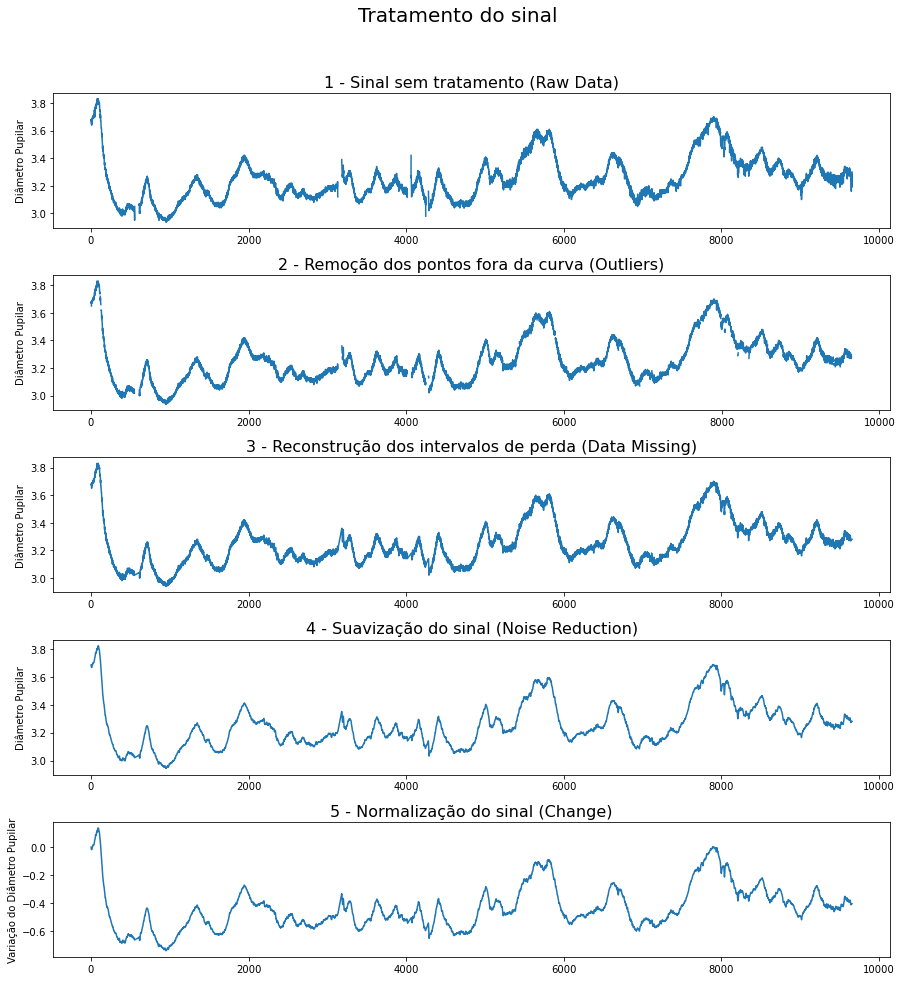

In [74]:
plt.figure(figsize = (15, 15)) # Configura tamanho da imagem

# Dados sem tratamento
dftemp = df.loc[(df["RecordingName"]==rec[14])&(df["MediaName"]==stimuli[0])] # Filtra o participante e o estímulo
x = list(range(1,len(dftemp['Pupil'])+1)) # Configura eixo das abscissas
y = dftemp["Pupil"] # Plota dado sem tratamento
plt.subplot(5, 1, 1)
plt.plot(x,y)
plt.title("1 - Sinal sem tratamento (Raw Data)", fontsize = 16)
plt.ylabel('Diâmetro Pupilar')

# Remoção de Outiliers
factor = 0.04 # Define um fator de filtro para outliers
for i in range(0,len(dftemp)-1):
    dif = abs(dftemp.iat[i,2]-dftemp.iat[i+1,2])
    if dif > factor or math.isnan(dif):
        dftemp.iat[i,2] = np.nan
# Verifica se há diferença entre amostras maiores que o fator ou se a amostra é NaN (em ordem decrescente)  
for i in range(len(dftemp)-1,0,-1):
    dif = abs(dftemp.iat[i,2]-dftemp.iat[i-1,2])
    if dif > factor or math.isnan(dif):
        dftemp.iat[i,2] = np.nan
                
y = dftemp["Pupil"] # Plota dado sem Outliers
plt.subplot(5, 1, 2)
plt.plot(x,y)
plt.title("2 - Remoção dos pontos fora da curva (Outliers)", fontsize = 16)
plt.ylabel('Diâmetro Pupilar')

# Faz a reconstrução do sinal por interpolação linear
y = dftemp.loc[:,'Pupil'].interpolate(method='linear', limit_direction='both') 
plt.subplot(5, 1, 3)
plt.plot(x,y)
plt.title("3 - Reconstrução dos intervalos de perda (Data Missing)", fontsize = 16)
plt.ylabel('Diâmetro Pupilar')

y = savgol_filter(y, 15, 3) # Suaviza o sinal para remover os ruídos
x = list(range(1,len(y)+1))
plt.subplot(5, 1, 4)
plt.plot(x,y)
plt.title("4 - Suavização do sinal (Noise Reduction)", fontsize = 16)
plt.ylabel('Diâmetro Pupilar')

# Dados após todas as etapas de tratamento
y = df2.loc[(df["RecordingName"]==rec[14])&(df2["MediaName"]==stimuli[0])] # Filtra o participante e o estímulo
x = list(range(1,len(y['Pupil'])+1)) # Configura eixo das abscissas
plt.subplot(5, 1, 5)
plt.plot(x,y['Pupil'])
plt.title("5 - Normalização do sinal (Change)", fontsize = 16)
plt.ylabel('Variação do Diâmetro Pupilar')

plt.suptitle("Tratamento do sinal", fontsize = 20)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.35)
plt.show()

## Passo 9 - Gravar arquivo com a base de dados tratada

In [75]:
# Salve a base de dados  
df2.to_csv('data_pupil.csv', index=False, sep="\t") # Grava arquivo